# 전력사용량 예측 AI 경진대회

* K-최근접 이웃 연습

### 데이터 설명(출처: kaggle)
##### train 데이터 :
* 60개 건물들의 2020년 6월 1일 부터 2020년 8월 24일까지의 데이터
* 1시간 단위로 제공
* 전력사용량(kWh) 포함
* train.shape: (122400, 10)
* num:건물번호
 
##### test 데이터 :
* 60개 건물들의 2020년 8월 25일 부터 2020년 8월 31일까지의 데이터
* 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)
* 전력사용량(kWh) 미포함
* test.shape: (10080, 9)
* num:건물번호

In [1]:
# 패키지 설치
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

## 데이터 불러오고 기본 정보 확인

In [2]:
# 데이터 불러오기
train= pd.read_csv('C:/Users/82102/Desktop/energy/train.csv',encoding='euc-kr')
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [3]:
# 데이터 불러오기
test= pd.read_csv('C:/Users/82102/Desktop/energy/test.csv', encoding='euc-kr')
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [5]:
# 결측값 확인
train.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [6]:
test.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

* test set에서만 결측값 존재

## 전처리

In [7]:
# 월, 일, 시간 변수 추가
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    
    return train

In [8]:
train = make_time(train)
test = make_time(test)

In [9]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22


## EDA

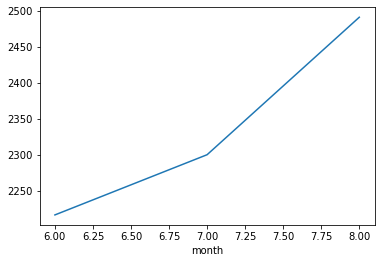

In [10]:
train.groupby(['month'])['전력사용량(kWh)'].mean().plot()

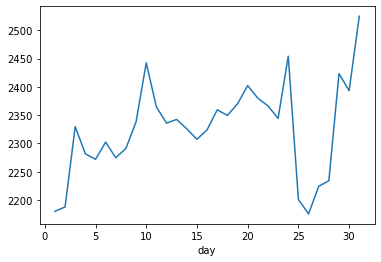

In [11]:
train.groupby(['day'])['전력사용량(kWh)'].mean().plot()

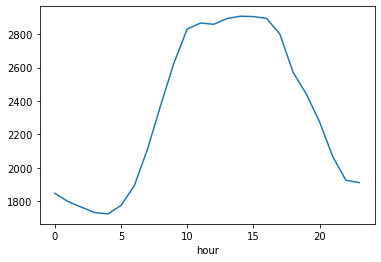

In [12]:
train.groupby(['hour'])['전력사용량(kWh)'].mean().plot()

## 모델링

In [13]:
# 타깃데이터 설정: 전력사용량(kWh)
target = train['전력사용량(kWh)']
data = train.drop(['전력사용량(kWh)', 'date_time'],axis = 1, inplace=False)

In [14]:
# 데이터 세트 분리
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size= 0.3, random_state=156)

In [15]:
# 표준화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

### K- 최근접 이웃 회귀 - 기본모델

In [16]:
from sklearn.neighbors import KNeighborsRegressor

In [17]:
KNN = KNeighborsRegressor()
KNN.fit(X_train, y_train)
KNN_preds = KNN.predict(X_val)

In [18]:
KNN_preds

array([ 589.8744 , 3524.65695, 1330.8714 , ..., 1420.524  , 7299.4608 ,
        941.7492 ])

In [19]:
# 결정계
print(KNN.score(X_val, y_val))

0.4230255328262119


In [20]:
from sklearn.metrics import mean_absolute_error
prediction = KNN.predict(X_val)
mae = mean_absolute_error(y_val, prediction)
print(mae)

940.2514422795927


* 예측이 평균적으로 940정도 타깃값과 다름

### 파라미터 조절

In [ ]:
knn_res = pd.DataFrame()
for i in range(20):
    clf = KNeighborsRegressor(n_neighbors=i+1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    train_score = clf.score(X_train, y_train)
    val_score = clf. score(X_val, y_val)
    
    knn_res = knn_res.append(pd.DataFrame([train_score, val_score]).T)
    
knn_res.columns = ['train', 'val']
knn_res = knn_res.reset_index(drop=True)
knn_res = knn_res.set_index(knn_res.index +1)

knn_res.plot(kind='line', figsize= (20, 5))